In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io
import skvideo
import skvideo.io
import torch
import torch as T
import scipy
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import torchvision as tv
from tqdm import tqdm
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
import skimage.transform
from importlib import reload
import fish_track as ft

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
reload(ft)

<module 'fish_track' from '/home/ubuntu/fish_track.py'>

In [3]:
directory = "/home/ubuntu/"
# filename = "20180410_1.mp4"
filename = "20180109_2.mp4"
vid_file = directory+filename

In [4]:
firstFrame = ft.get_first_frame(vid_file)
frames = ft.get_n_frames(vid_file)

plt.imshow(firstFrame)

# ROI selection

In [ ]:
pad = 30
maxThreshold = 30
minThreshold = 7

frame = np.full([pad*2+firstFrame.shape[0],pad*2+firstFrame.shape[1]], 1)
frame[pad:-pad,pad:-pad] = denoise_tv_chambolle(frames[11,:,:,0]).copy()*255
frame[frame>maxThreshold] = maxThreshold
frame[frame<minThreshold] = 0
# plt.imshow(frame)
# plt.colorbar()

fishCenter = (pad+235,pad+190)
pad = 200

fishROI = ft.selectROI(frame,fishCenter, pad)

# fishROI = normalize(fishROI, norm='l2')
fishROI = fishROI - fishROI.mean()
# fishROI = (fishROI - fishROI.mean())/fishROI.std()
# fishROI = fishROI - fishROI.sum()/len(fishROI)
fishROI = fishROI.astype(np.float32)

fishROI[pad,pad] = np.max(fishROI)*2
plt.imshow(fishROI)
plt.colorbar()
imageW, imageH = firstFrame.shape[:-1]

In [ ]:
dtype = np.float32
filters = ft.ROI_to_filters(frame, fishCenter, pad, imageW, imageH, 16,dtype=dtype)
filters_fft = ft.ROI_to_filters(frame, fishCenter, pad, imageW, imageH, 16, fft=True)

In [12]:
def viz_find_position(img, filters, fft=False,dtype=np.float32):
    nrow = int(np.ceil(np.sqrt(filters.shape[0])))
    ncol = nrow
    plt.imshow(img)
    if fft:
        hm = ft.heatmap_fft(img[:,:,0].astype(dtype),filters)
    else:
        hm = ft.heatmap(img[:,:,0].astype(dtype),filters)
    print("Best: filter={}, x={}, y={}".format(*np.unravel_index(np.argmax(hm),hm.shape)))
    plt.subplots(nrow,ncol,figsize=(15,15))
    for i in range(hm.shape[0]):
        plt.subplot(nrow,ncol,1+i)
        h = hm[i].cpu().numpy().astype(np.float32)
        m = np.unravel_index(np.argmax(h),h.shape)
        image = ft.drawROI(ft.scale_range(h[:,:,None],0,1).repeat(3,2),m[0],m[1],7,80,5,use_float=True)
        plt.imshow(image)
        plt.title("filter {}".format(i))

    plt.subplots(nrow,ncol,figsize=(12,12))
    for i in range(hm.shape[0]):
        plt.subplot(nrow,ncol,1+i)
        f = filters[i].cpu().numpy().astype(np.float32)
        if fft:
            f = f[:,:,0]
        plt.imshow(f)
        plt.title("filter {}".format(i))

# viz_find_position(frames[7], filters)

In [11]:
f = frames[7]
img = f[:,:,0].astype(dtype)

# FFT conv validation (failing)

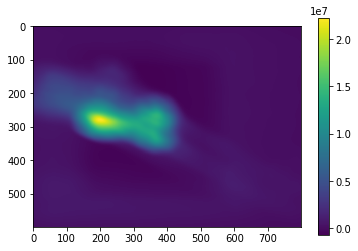

In [48]:
plt.imshow(ft.heatmap(img, filters).cpu().numpy()[0].astype(np.float32))
plt.colorbar()

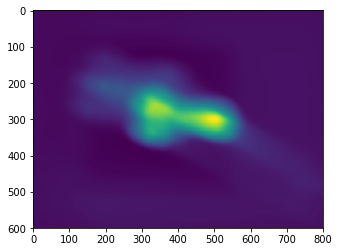

In [56]:
plt.imshow(scipy.signal.fftconvolve(img.astype(np.float32),filters[0],mode='same'))

In [69]:
int(filters.shape[1]/2)

200

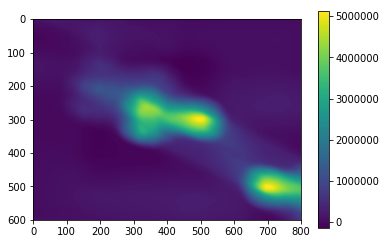

In [70]:
start = int(filters.shape[1]/2)
i_end = start+img.shape[0]
j_end = start+img.shape[1]
plt.imshow(ft.heatmap_fft(image, filters_fft)[0,start:i_end,start:j_end])
plt.colorbar()

In [79]:
def selectROI(img,center,pad):
    return img[center[0]-pad:center[0]+pad,center[1]-pad:center[1]+pad]

def rotateImage(img, angle, pivot):
    padX = [img.shape[1] - pivot[1], pivot[1]]
    padY = [img.shape[0] - pivot[0], pivot[0]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = scipy.ndimage.rotate(imgP, angle, reshape=False)
    return imgR[padY[0] : -padY[1], padX[0] : -padX[1]]

def ROI_to_filters(img, center, pad, imageW, imageH, nfilters=8, fft=False, dtype=np.float32):
    filter_size = 2*pad
    # we will use the center of the img plus a pad to create rotationally invariant filters
    filters = np.zeros([nfilters,filter_size,filter_size]).astype(np.float64)
    norm = (img - img.mean()).astype(np.float64) # subtract mean
    for i in range(nfilters):
        # rotate the image first around the provided pivot
        rot = rotateImage(norm, i * 360 / nfilters, center)
        # select the ROI for the filter
        filters[i] = rot[center[0]-pad:center[0]+pad,center[1]-pad:center[1]+pad]
        
    if fft:
        complex_filters = T.cuda.FloatTensor(nfilters,imageW*2-1, imageH*2-1, 2).zero_()
        complex_filters[:,0:filter_size,0:filter_size,0] = T.from_numpy(filters)
        return T.fft(complex_filters,2)
    else:
        return T.from_numpy(filters.astype(dtype)).cuda()
    
filters_fft = ROI_to_filters(frame, fishCenter, pad, imageW, imageH, 16, fft=True)

In [82]:
image = np.zeros(np.array(img.shape)*2-1)
image[0:img.shape[0],0:img.shape[1]] = img

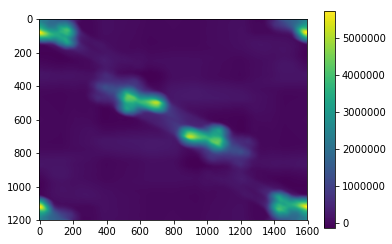

In [83]:
plt.imshow(ft.heatmap_fft(image, filters_fft)[0])
plt.colorbar()

In [41]:
t_conv = ft.heatmap(img, filters).cpu().numpy()[0].astype(np.float32)

viz_find_position(frames[7], filters)

In [31]:
reload(ft)

<module 'fish_track' from '/home/ubuntu/fish_track.py'>

viz_find_position(frames[7], filters_fft, fft=True)

# Benchmarking

In [119]:
%%timeit -r 3 -n 3
pos = heatmap_fft(img,filters_fft,shape)

1.34 ms ± 5.78 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [120]:
%%timeit -r 3 -n 3
# for some reason, pytorch argmax is performing very slowly.
pos = find_position_fft(img,filters_fft,shape)

303 ms ± 4.82 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [126]:
%%timeit -r 3 -n 3
# numpy's argmax is performing much better, but this is suboptimal
# as must transfer entire image back to CPU
pos = find_position_fft_np_argmax(img,filters_fft,shape)

11.9 ms ± 530 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [121]:
%%timeit -r 3 -n 3
pos = heatmap(img,filters,shape)

465 ms ± 81.8 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [122]:
%%timeit -r 3 -n 3
pos = find_position(img,filters)

520 ms ± 2.44 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [18]:
%%timeit -r 3 -n 3
pos = find_position_threshold(img,filters)

873 ms ± 5.94 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [43]:
np.array(img.shape)/2

array([300., 400.])

In [58]:
%%timeit -r 3 -n 3
F.avg_pool2d(T.from_numpy(img[None]),2)

1.69 ms ± 24.1 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
